### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [1]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

from sklearn.preprocessing import OneHotEncoder, StandardScaler

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

VERBOSE = 1
CV = [(slice(None), slice(None))]
TESTING = False

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-04-19 08:51:00.979557: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 08:51:02.027617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
ITER = 2

hyperparameterspace = {
    'epochs': ["interval-int", 1, 10],
    'batch_size': ["interval-int", 10, 200],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.01],
    'model__neurons_per_layer': ["interval-int", 1, 100],
    'model__number_of_layers': ["interval-int", 1, 10],
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [3]:
ids = [233214, 233211, 359935, 359952, 359940, 359931]#, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

valid_datasets = 0
for i in range(len(ids)):
    print("######################################################################################################################################################")
    print("Current Dataset:", (i+1), "of", len(ids), "with id:", ids[i])

    dataset = HPO.Dataset(task_id=ids[i])

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(neurons_per_layer=20, number_of_layers=1): 
        # create model
        model = Sequential()
        model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
        for _ in range(number_of_layers):
            model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
        model.add(Dense(1, activation=None))

        optimizer = keras.optimizers.Adam(learning_rate=0.001)

        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model


    def blackboxfunction(params):
        #index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
        
        epochs = int(params[0])

        batch_size = int(params[1])

        model_learning_rate = params[2]

        neurons_per_layer = int(params[3])

        number_of_layers = int(params[4])

        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
            for _ in range(number_of_layers):
                model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
            model.add(Dense(1, activation=None))
            # Compile model
            
            optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

            model.compile(loss=loss, optimizer=optimizer)
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

        if TESTING:
            Y_predicted = model.predict(dataset.get_X_test())
            result = -sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)
            K.clear_session()
            return result 
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            result = -sklearn.metrics.mean_squared_error(dataset.get_Y_validation(), Y_predicted)
            K.clear_session()
            return result
        
    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
            
            epochs = int(from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = from_standard(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[2])
            
            neurons_per_layer = int(from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))

            number_of_layers = int(from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))

            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
                for _ in range(number_of_layers):
                    model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
                model.add(Dense(1, activation=None))
                # Compile model
                
                optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

                model.compile(loss=loss, optimizer=optimizer,)
                return model

            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
                K.clear_session()
                return result
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
                K.clear_session()
                return result
            


    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = (j+1)*len(hyperparameterspace.keys())
        print("\n################################################## Current Budget:", BUDGET, "##################################################")

        ############################## GRID SEARCH #######################
        print("Performing grid search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by grid search:")
            print(result.best_params_)
        
        Y_predicted = result.predict(dataset.get_X_test())

        GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        GRID_COST.append(cost)

        K.clear_session()

        ########################### RANDOM SEARCH #######################
        print("Performing random search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        if VERBOSE > 0:
            print("Best params found by random search:")
            print(result.best_params_)

        Y_predicted = result.predict(dataset.get_X_test())

        RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        RANDOM_COST.append(cost)

        K.clear_session()

        ########################### BAYESIAN OPT ##################### 
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


        result = optimization.fit()
        
        index_best = 0
        for m in range(len(result[1])):
            if result[1][m] == max(result[1]):
                index_best = i

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        if VERBOSE > 0:
            print("With Hyperparameters: ")
            i = 0
            for key in hyperparameterspace.keys():
                if hyperparameterspace[key][0] == "list":
                    index = int(best_params[i]*(len(hyperparameterspace_special[key])-1))
                    print(key + ": " + str(hyperparameterspace_special[key][index]))
                else:
                    print(key + ": " + str(best_params[i]))
                i += 1

        TESTING = True
        BAYESIAN_RESULT.append(-blackboxfunction(best_params))
        TESTING = False

        BAYESIAN_COST.append(BUDGET)

        K.clear_session()

        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="gradient_descent")

        result = optimization.fit()

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        TESTING = False

        SPARSE_COST.append(BUDGET)
        SPARSE_COST_OPTIMIZED.append(BUDGET)

        K.clear_session()
    



######################################################################################################################################################
Current Dataset: 1 of 6 with id: 233214

################################################## Current Budget: 5 ##################################################
Performing grid search
Fitting 1 folds for each of 1 candidates, totalling 1 fits


2023-04-19 08:51:07.731498: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Best params found by grid search:
{'batch_size': 105, 'epochs': 5, 'model__neurons_per_layer': 50, 'model__number_of_layers': 5, 'optimizer__learning_rate': 0.00500005}
Performing random search
Fitting 1 folds for each of 5 candidates, totalling 5 fits
Best params found by random search:
{'batch_size': 197, 'epochs': 9, 'model__neurons_per_layer': 51, 'model__number_of_layers': 5, 'optimizer__learning_rate': 0.009657339773554536}
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 11.222414365999953 seconds
With Hyperparameters: 
epochs: 2.5853349662512835
batch_size: 113.65571613016532
optimizer__learning_rate: 0.00013998276371112697
model__neurons_per_layer: 32.8608109733821
model__number_of_layers: 3.0274622271581997
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 121503ms.
Solving linear system (automatic method)...
Done in 5ms.

Optimal hyperparameters so far:
epochs: 3.25
batch_size: 105.0
optimizer__learning_rate: 0.007500025000000001
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss:
0.8853992710739729
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 1.0000041016379086
batch_size: 10.000079986382085
optimizer__learning_rate: 0.009999991757894976
model__neurons_per_layer: 99.9999415273858
model__number_of_layers: 1.0000078647095183
Resulting loss (Optimal value from optimization):
-7.425421161889906
Resulting loss (Optimal point evaluated

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 27.733505219999188 seconds
With Hyperparameters: 
epochs: 9.044464188377567
batch_size: 16.71052956407333
optimizer__learning_rate: 0.008200504274786908
model__neurons_per_layer: 47.39405897360672
model__number_of_layers: 6.810127161842954
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 88959ms.
Solving linear system (automatic method)...
Done in 1ms.

Optimal hyperparameters so far:
epochs: 7.75
batch_size: 105.0
optimizer__learning_rate: 0.007500025000000001
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss:
0.6212227684510343
Optimizing (gradient descent)...
Done in 1ms.

Optimal hyperparameters after optimization:
epochs: 9.999993398066403
batch_size: 10.000160953747427
optimizer__learning_rate: 0.009999997066617814
model__neurons_per_layer: 99.999946996601
model__number_of_layers: 1.0000067798700158
Resulting loss (Optimal value from optimization):
-0.20682807120698274
Resulting loss (Optimal point evaluated):
0.

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 17.052885708999383 seconds
With Hyperparameters: 
epochs: 5.510802819736968
batch_size: 131.00844576779036
optimizer__learning_rate: 0.0019143689589665562
model__neurons_per_layer: 18.2513817084019
model__number_of_layers: 5.43746704201361
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 157248ms.
Solving linear system (automatic method)...
Done in 7ms.

Optimal hyperparameters so far:
epochs: 7.75
batch_size: 105.0
optimizer__learning_rate: 0.005000050000000001
model__neurons_per_layer: 75.25
model__number_of_layers: 5.5
Resulting loss:
0.46161467991999316
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 9.999996481749617
batch_size: 10.000090186308313
optimizer__learning_rate: 1.0141814723137657e-07
model__neurons_per_layer: 99.99990849030218
model__number_of_layers: 9.999993172772722
Resulting loss (Optimal value from optimization):
-0.6511737833270312
Resulting loss (Optimal point evaluated

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 63.14566710700001 seconds
With Hyperparameters: 
epochs: 2.505386010499779
batch_size: 148.1561725332295
optimizer__learning_rate: 0.006608821905909499
model__neurons_per_layer: 37.92807860953478
model__number_of_layers: 8.033478693635207
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 285450ms.
Solving linear system (automatic method)...
Done in 3ms.

Optimal hyperparameters so far:
epochs: 8.875
batch_size: 105.0
optimizer__learning_rate: 0.005000050000000001
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss:
0.4541791470192732
Optimizing (gradient descent)...
Done in 0ms.

Optimal hyperparameters after optimization:
epochs: 9.394608619625545
batch_size: 105.00224423700914
optimizer__learning_rate: 0.0040854835515231405
model__neurons_per_layer: 62.8749962255959
model__number_of_layers: 5.4445689880782036
Resulting loss (Optimal value from optimization):
0.3700325781402315
Resulting loss (Optimal point evaluated):
0

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 15.510697547000746 seconds
With Hyperparameters: 
epochs: 3.2642013052618117
batch_size: 65.65156648130917
optimizer__learning_rate: 0.003908481120735982
model__neurons_per_layer: 83.80164980630066
model__number_of_layers: 6.603352994902712
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 170461ms.
Solving linear system (automatic method)...
Done in 7ms.

Optimal hyperparameters so far:
epochs: 5.5
batch_size: 152.5
optimizer__learning_rate: 0.005000050000000001
model__neurons_per_layer: 50.5
model__number_of_layers: 7.75
Resulting loss:
0.7771841750725366
Optimizing (gradient descent)...
Done in 1ms.

Optimal hyperparameters after optimization:
epochs: 6.625000024347986
batch_size: 10.000044798604911
optimizer__learning_rate: 1.0483510760424211e-07
model__neurons_per_layer: 50.50000012214268
model__number_of_layers: 9.99999322301221
Resulting loss (Optimal value from optimization):
-0.011154137293382091
Resulting loss (Optimal point evaluated

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 34.011413644000186 seconds
With Hyperparameters: 
epochs: 7.159357960493418
batch_size: 137.90410964518554
optimizer__learning_rate: 0.005511050267020263
model__neurons_per_layer: 55.856248649229556
model__number_of_layers: 2.275725471633393
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 169525ms.
Solving linear system (automatic method)...
Done in 9ms.

Optimal hyperparameters so far:
epochs: 5.5
batch_size: 105.0
optimizer__learning_rate: 0.005000050000000001
model__neurons_per_layer: 75.25
model__number_of_layers: 7.75
Resulting loss:
0.7657967992418104
Optimizing (gradient descent)...
Done in 1ms.

Optimal hyperparameters after optimization:
epochs: 1.0000052606753898
batch_size: 199.99994563483955
optimizer__learning_rate: 1.0851951041887335e-07
model__neurons_per_layer: 99.99999583751136
model__number_of_layers: 1.0000039376430996
Resulting loss (Optimal value from optimization):
-2.3835367931607436
Resulting loss (Optimal point evalua

/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 13.00627172700024 seconds
With Hyperparameters: 
epochs: 2.6023218703262323
batch_size: 36.2153500425451
optimizer__learning_rate: 0.0025492274507761285
model__neurons_per_layer: 30.53838518690154
model__number_of_layers: 4.834527205768046
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 104773ms.
Solving linear system (automatic method)...
Done in 5ms.

Optimal hyperparameters so far:
epochs: 5.5
batch_size: 81.25
optimizer__learning_rate: 0.005000050000000001
model__neurons_per_layer: 50.5
model__number_of_layers: 5.5
Resulting loss:
0.9665097407378874
Optimizing (gradient descent)...
Done in 1ms.

Optimal hyperparameters after optimization:
epochs: 5.4999999859258715
batch_size: 41.20680736306808
optimizer__learning_rate: 0.009999995513397883
model__neurons_per_layer: 99.99995230042832
model__number_of_layers: 9.999994769365156
Resulting loss (Optimal value from optimization):
-0.6937600871430112
Resulting loss (Optimal point evaluated):
1.

[0.88462245, 0.9217723, 0.022739531, 0.022285085, 0.6062208, 0.6033983, 0.44790727, 0.4131316, 0.8939853, 0.9102848, 1.0519006, 1.01445]
[0.977145, 0.994171, 0.019443728, 0.019533468, 0.6148988, 0.58859026, 0.41404805, 0.3790393, 0.9287102, 0.9246153, 1.0414512, 0.9856487]
[0.8747267, 0.85619754, 0.021908116, 0.025311578, 0.61786115, 0.6318451, 0.45329976, 0.45891753, 0.8371556, 0.9943241, 0.9934787, 0.8901076]
[0.9079067866869158, 0.9851584126636802, 0.026285410764205323, 0.023378603631710234, 0.615348958359108, 0.6249381895462285, 0.43627539906823115, 0.39855144458492053, 0.848586427677968, 0.8890810709190378, 0.949497884944888, 0.9599252450123107]
[0.8979294575840996, 0.8776164634585665, 0.07040742584494661, 0.02505343433976055, 0.6020366141694355, 0.619042938728687, 0.9347497749044801, 0.375101836978437, 0.8897680230648252, 1.1400965688177132, 1.0597994616119595, 1.0093510674947166]
Current dataset: 0 with name id: 233214


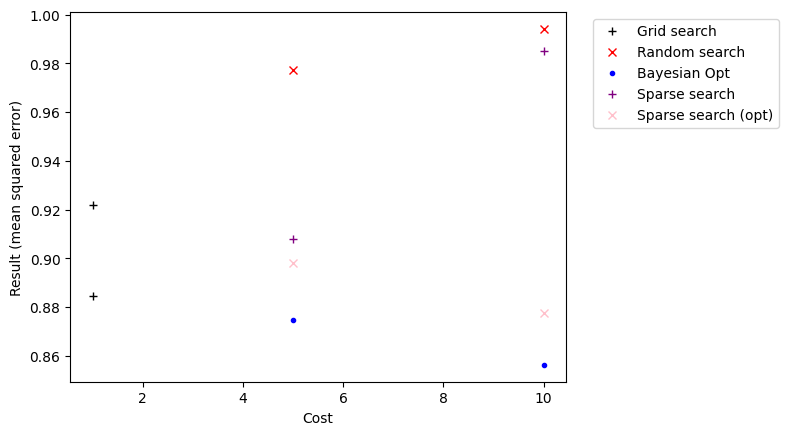

Current dataset: 1 with name id: 233211


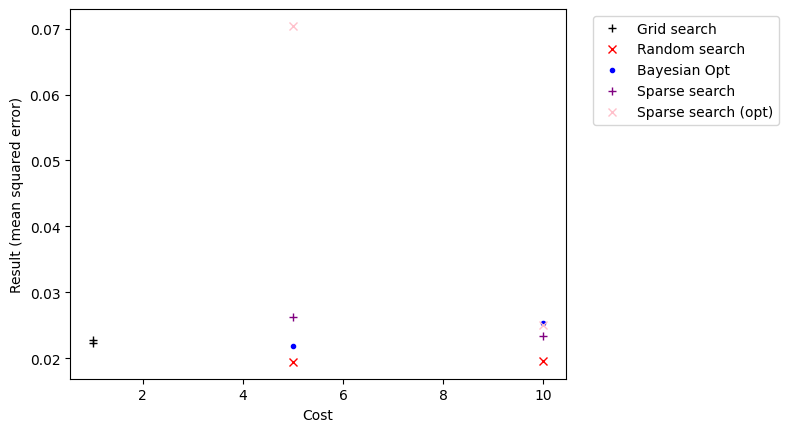

Current dataset: 2 with name id: 359935


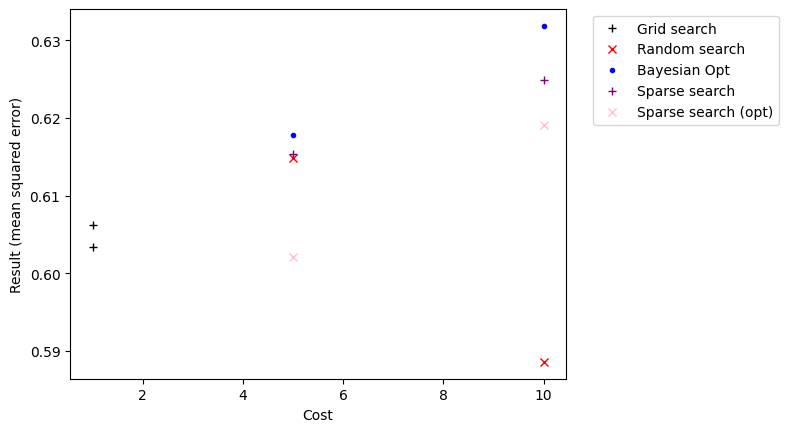

Current dataset: 3 with name id: 359952


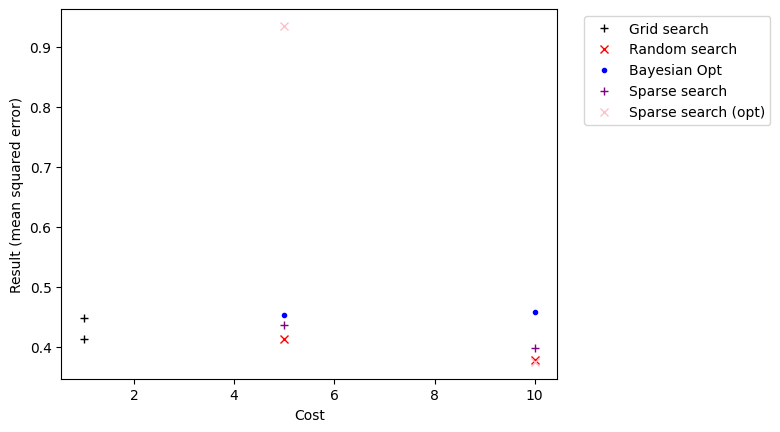

Current dataset: 4 with name id: 359940


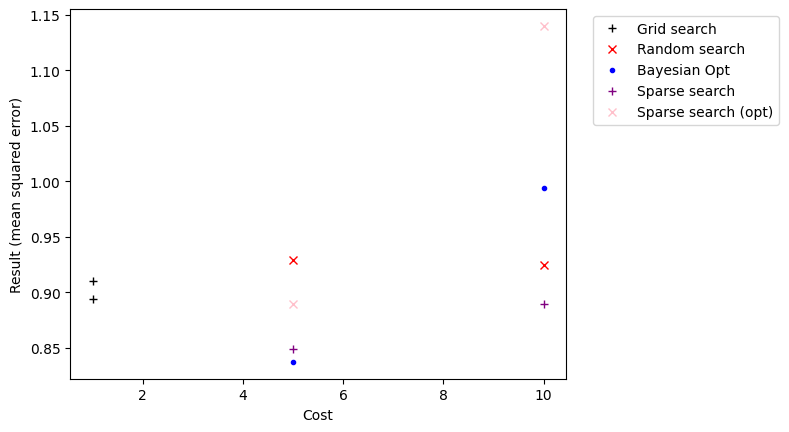

Current dataset: 5 with name id: 359931


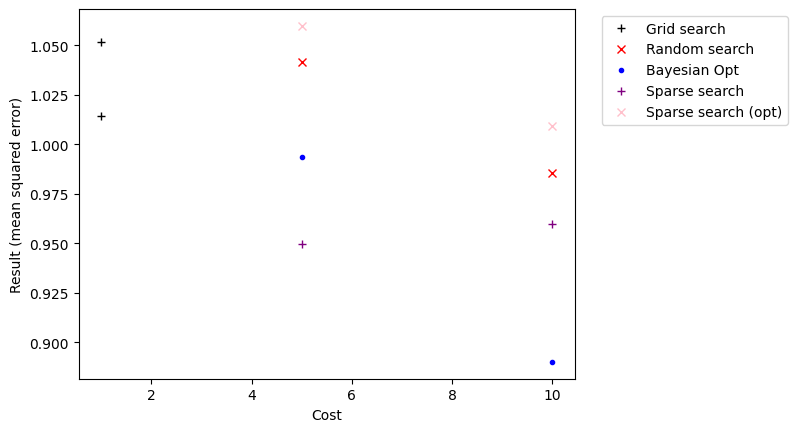

In [4]:
print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
count = 0
for i in range(len(ids)):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        #plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

